In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import scipy as sc

from tqdm.notebook import tqdm

In [2]:
# Preliminaries
erf = sc.special.erf
pi = np.pi

# Define mean thermal excitation
nbar_cav = 0.001  # 0
nbar_qb = 0.009  # corresponds to pe=0.017

# Simulation Dimensions
cdim = 30
qdim = 2

# Loss
loss = 'all'  # 'all', 'only-kerr' ,'perfect-measure', 'no-kerr', 'none'

# Filename
filename = 'g_0_plus_alpha05'

data_dr = np.load("ae/pulses/"+filename+"_forward.npz", "r")

# Initial State
rho = tensor(thermal_dm(qdim, nbar_qb), thermal_dm(cdim, nbar_cav))

rho_target = tensor(thermal_dm(qdim, 0), ket2dm((coherent(cdim,0)+coherent(cdim,0.5)).unit()))

/opt/anaconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


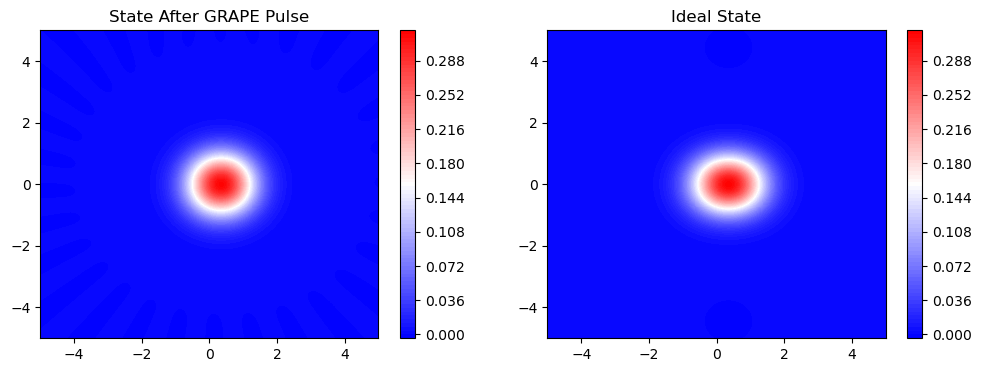

max recon is 0.3171356545317412
min recon is -4.234159236322502e-09
max ideal is 0.3179295189336976
min ideal is -1.88699724168241e-09
0.988


In [3]:
dt = data_dr['dt']
# the drives are already in GHz
qubitI = data_dr['QubitI']
qubitQ = data_dr['QubitQ']
cavI = data_dr['CavityI']
cavQ = data_dr['CavityQ']

# Mode Operators
q = destroy(qdim)
c = destroy(cdim)
qd, cd = q.dag(), c.dag()

Q = tensor(q, qeye(cdim))
C = tensor(qeye(qdim), c)
Qd, Cd = Q.dag(), C.dag()

# Hamiltonian Parameters in GHz
chi = 1.359e-3
# alpha = 224.4e-3
# alpha *= 2*pi

# Coherences in ns
if (loss != 'none') and (loss != 'only-kerr'):
    Kerr = -6e-6
    chi2 = -15.75e-6
    T1 = 96e3
    T2 = 15.47e3
    Tphi = 1/(1/T2 - 0.5/T1)
    cavT1 = 1e6
else:
    Kerr = 0
    chi2 = 0
    T1 = np.inf
    T2 = np.inf
    Tphi = np.inf
    cavT1 = np.inf

if loss == 'no-kerr': Kerr = 0
if loss == 'only-kerr': Kerr = -6e-6

# Drift Hamiltonian
H0 = -2*pi*chi*Cd*C*Qd*Q + 2*pi*chi2/2 *Cd*Cd*C*C*Qd*Q + 2*np.pi*Kerr/2*Cd*Cd*C*C + 2*pi*chi/150 * Cd*C#- alpha/2 * Qd*Qd*Q*Q

tlist = [dt*i for i in range(len(cavQ))]

def drive_amp(t, drive):
    '''Returns the drive amplitude for a given time'''
    drive_index = t//dt
    drive_index = int(drive_index)

    if drive_index == len(cavQ):
        drive_index -= 1

    return drive[drive_index]

H_drive = [
    [2*pi*(Q + Qd), lambda t, *args: drive_amp(t, qubitI)],
    [2j*pi*(Q - Qd), lambda t, *args: drive_amp(t, qubitQ)],
    [2*pi*(C + Cd), lambda t, *args: drive_amp(t, cavI)],
    [2j*pi*(C - Cd), lambda t, *args: drive_amp(t, cavQ)],
]

H = [H0, *H_drive]

# Collapse Operators
c_ops = [
    # Qubit Relaxation
    np.sqrt((1 + nbar_qb)/T1) * Q,
    # Qubit Thermal Excitations
    np.sqrt(nbar_qb/T1) * Qd,
    # Qubit Dephasing
    np.sqrt(2/Tphi) *Qd*Q,#changed
    # Cavity Relaxation
    np.sqrt((1 + nbar_cav)/cavT1) * C,
    # Cavity Thermal Excitations
    np.sqrt(nbar_cav/cavT1) * Cd,
]

# Dynamics
options = Options(max_step = 2, nsteps = 1e6)
results = mesolve(H, rho, tlist, c_ops = c_ops, options = options)#, progress_bar = True)

cav_state = results.states[-1].ptrace(1)#.tidyup(1e-2)

F = np.round(fidelity(results.states[-1], rho_target)**2,3)

if 1:
    # Find the Wigner function of the cavity state
    cav_state = results.states[-1].ptrace(1)

    xvec = np.linspace(-5, 5, 200)
    fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi = 100)

    state_wigner = wigner(cav_state, xvec, xvec,)
    cont0 = axes[0].contourf(xvec, xvec, state_wigner, 100, cmap = 'bwr')
    cb0 = fig.colorbar(cont0, ax=axes[0])
    axes[0].set_title("State After GRAPE Pulse")

    ideal =  rho_target.ptrace(1)#1*fock(cdim, 1)
    # ideal /= np.sqrt(2)
    state_wigner_id = wigner(ideal, xvec, xvec)
    cont1 = axes[1].contourf(xvec, xvec, state_wigner_id, 100, cmap = 'bwr')
    cb1 = fig.colorbar(cont1, ax=axes[1])
    axes[1].set_title("Ideal State")

    plt.show()
    print('max recon is '+str(np.max(state_wigner)))
    print('min recon is '+str(np.min(state_wigner)))
    print('max ideal is '+str(np.max(state_wigner_id)))
    print('min ideal is '+str(np.min(state_wigner_id)))

rho_prep = results.states[-1]#this is now the starting state
print(F)

### Load parameters and calibrate pi pusle

In [14]:
data_dr = np.load("ae/pulses/"+filename+"_back.npz", "r")

dt = data_dr['dt']
# the drives are already in GHz
qubitI = data_dr['QubitI']
qubitQ = data_dr['QubitQ']
cavI = data_dr['CavityI']
cavQ = data_dr['CavityQ']

# Mode Operators
q = destroy(qdim)
c = destroy(cdim)
qd, cd = q.dag(), c.dag()

Q = tensor(q, qeye(cdim))
C = tensor(qeye(qdim), c)
Qd, Cd = Q.dag(), C.dag()

tlist = [dt*i for i in range(len(cavQ))]

def drive_amp(t, drive):
    '''Returns the drive amplitude for a given time'''
    drive_index = t//dt
    drive_index = int(drive_index)

    if drive_index == len(cavQ):
        drive_index -= 1

    return drive[drive_index]

H_drive = [
    [2*pi*(Q + Qd), lambda t, *args: drive_amp(t, qubitI)],
    [2j*pi*(Q - Qd), lambda t, *args: drive_amp(t, qubitQ)],
    [2*pi*(C + Cd), lambda t, *args: drive_amp(t, cavI)],
    [2j*pi*(C - Cd), lambda t, *args: drive_amp(t, cavQ)],
]

H = [H0, *H_drive]


ug = fock_dm(qdim,0)
u0 = fock_dm(cdim,0)

# Collapse Operators
c_ops = [
    # Qubit Relaxation
    np.sqrt((1 + nbar_qb)/T1) * Q,
    # Qubit Thermal Excitations
    np.sqrt(nbar_qb/T1) * Qd,
    # Qubit Dephasing
    np.sqrt(2/Tphi) *Qd*Q,#changed
    # Cavity Relaxation
    np.sqrt((1 + nbar_cav)/cavT1) * C,
    # Cavity Thermal Excitations
    np.sqrt(nbar_cav/cavT1) * Cd,
]

#power rabi calibration
calibration = [
    (1, 250, 4),#tuple
]

A, sigma, chop = calibration[0]
freq_detune = 0
if 1:
        '''
        Power Rabi: Use this to calibrate the amplitude needed to drive a qubit pi pulse
        '''
        amp = np.linspace(0, 1.5, 199)
        output = []

        for Ax in amp:
            A = np.sqrt(2/np.pi) / erf(np.sqrt(2))*np.pi/(4*sigma)/2/np.pi#initial guess
            A0 = A#keep it for later

            frq = 0#resonant driving

            A *= Ax#coefficient for the Gaussian pulse

            H0q = 2*np.pi*frq * qd*q
            # Hd = 2*np.pi*A*1j*(qd - q)#or with other part
            Hdq = 2*np.pi*A*(qd + q)

            def pulse(t, *arg):
                global sigma, chop
                t0 = sigma*chop/2

                g = np.exp( - 1/2 * (t - t0)**2 / sigma**2)

                return g

            Hq = [H0q, [Hdq, pulse]]

            #initial state
            # psi = basis(2, 0)
            rhoq = thermal_dm(qdim, nbar_qb)#ket2dm(psi)

            tlistq = np.linspace(0, sigma*chop, 101)

            c_opsq = [
                np.sqrt((1 + nbar_qb)/T1)*q,
                np.sqrt(nbar_qb/T1) * qd,
                np.sqrt(2/Tphi)*qd*q#changed
            ]

            e_opsq = [qd*q,]

            # options = Options(max_step = 1, nsteps = 1e6)

            results = mesolve(Hq, rhoq, tlistq, c_ops= c_opsq, e_ops = e_opsq)#, options= options)#, progress_bar = True)

            output += [results.expect[0][-1],]

        # print(max(output), output.index(max(output)), amp[output.index(max(output))])
        A = A0*amp[output.index(max(output))]#this is the correct coeff



### Simulation

  0%|          | 0/51 [00:00<?, ?it/s]

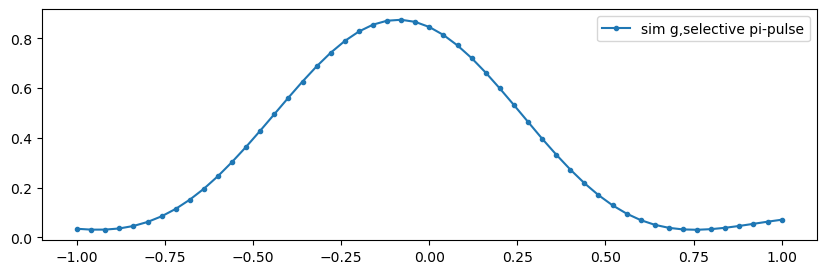

In [15]:
#the wait time
# twait = np.linspace(0,2*pi/(2*pi*chi),21)
#max wait time is 400ns
t_displace = 4 * 27
n_points = 51
d_values = np.linspace(-1, 1, n_points)
d_coeff = d_values / t_displace


Pg0 = np.zeros(len(d_values),dtype=float)
P = np.zeros(len(d_values),dtype=float)
pfirst = np.zeros(len(d_values),dtype=float)
for k in tqdm(range(len(d_values))):
    H_displacement = d_coeff[k] * C + np.conj(d_coeff[k]) * Cd
    options = Options(max_step = 2, nsteps = 1e6)
    results1 = mesolve(H0+H_displacement, rho_prep, [0,t_displace], c_ops = c_ops, options = options)

    # Dynamics for O2
    options = Options(max_step = 2, nsteps = 1e6)
    results = mesolve(H, results1.states[-1], tlist, c_ops = c_ops, options = options)#, progress_bar = True)

    Pg0[k] = (results.states[-1]*tensor(ug*ug.dag(),u0*u0.dag())).tr()
    #the state after projection in g
    g_projector = Qobj([[0.992, 0], [0, 0.008]]) if loss == 'all' or loss == 'no-kerr' else ug*ug.dag()

    Rf = tensor(g_projector,qeye(cdim))*results.states[-1]*tensor(g_projector,qeye(cdim))
    pfirst[k] = (Rf).tr()
    Rf = Rf/(Rf).tr()

    #wait for the first rr
    # tlistw = np.linspace(0, 2.4e3, 101)
    # resultsw = mesolve(H0, Rf, tlistw, c_ops = c_ops, options = options)

    #now the selective pi-pulse
    RHO_tar = Rf#resultsw.states[-1]#Rf

    frq = freq_detune
    H0 = -2*np.pi*frq * Qd*Q - 2*np.pi*chi*Qd*Q*Cd*C + 2*pi*chi2/2 *Cd*Cd*C*C*Qd*Q + 2*np.pi*Kerr/2*Cd*Cd*C*C + 2*pi*chi/150 * Cd*C
    # Hd = 2*np.pi*1j*(Qd - Q)
    Hd = 2*np.pi*(Qd + Q)

    def pulse(t, *arg):
        t0 = sigma*chop/2
        g = A*np.exp( - 1/2 * (t - t0)**2 / sigma**2)

        return g

    Hrpi = [H0, [Hd, pulse]]

    e_ops = [tensor(Qobj([[0.008, 0], [0, 0.992]]), qeye(cdim)),] if loss == 'all' or loss == 'no-kerr' else [Qd*Q,]
    # e_ops =

    # options = Options(max_step = 4, nsteps = 1e6)
    results2 = mesolve(Hrpi, RHO_tar, tlistq, c_ops= c_ops, e_ops = e_ops)#, options = options)#, progress_bar = True)
    P[k] = results2.expect[0][-1].real

    # flip = tensor((-1j*sigmax()*np.pi/2).expm(),u0*u0.dag())+tensor(qeye(qdim),qeye(cdim)-u0*u0.dag())
    # rf = flip*RHO_tar*flip.dag()
    # P[k] = (rf*Qd*Q).tr()


if loss == 'none': loss_name = '_id'
elif loss == 'all': loss_name = '_all'
elif loss == 'perfect-measure': loss_name = '_pm'
elif loss == 'no-kerr': loss_name = '_nk'
elif loss == 'only-kerr': loss_name = '_k'
else: loss_name = loss

np.savez('ae/sim/'+filename+loss_name+'.npz',
x=d_values,
probability_sim=P*pfirst
)


#%%
plt.figure(figsize=(10,3))
plt.plot(d_values, P*pfirst,'.-',label='sim g,selective pi-pulse')
plt.legend()
plt.show()